<a href="https://colab.research.google.com/github/dlvvkfl88/MSAISCHOOL/blob/main/MS_AI_SCHOOL_63%EC%9D%BC%EC%B0%A8_CNN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG NET 구조소개

In [1]:
import torch
import torch.nn as nn

In [4]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(7, 7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x


In [5]:
import torch
import torch.nn as nn

### ResNet 기본 블럭 정의

In [6]:
class BasicBlock(nn.Module) :

    expansion = 1 # 확장 비율 변수 => ResNet block 채널수를 확장하는 경우에 필요에 의해서 숫자를 늘려주시면됩니다. (기본 1)

    def __init__(self, in_channels, out_channels, stride=1) :
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        """
        BatchNorm2d() -> 딥러닝에서 모델 학습시 안정적인 학습 하기 위한 기법 -> gradient vanishing 문제를 해결 가능
        입력의 각 채널에 대해서 평균, 분산 계산하고 정규화된 출력을 생성
        """
        self.relu = nn.ReLU(inplace=True)
        """
        in_channels => 입력 특징 맵의 채널 수
        out_channels => 출력 특징 맵의 채널 수
        kernel_size => 컨불루션 커널의 크기
        stride => 컨불루션 보폭 크기
        bias => 편향값을 사용할지에 대한 여부

        padding = 1 ===> 입력과 출력의 공간적인 크기를 보존 가능
        bias=True -> 편향값을 컨불루션 레이어에 값을 추가 -> 모델 좀더 유연하게 학습 시키기 위함
        """

        """
        stride 와 in_channels 1이 아닌경우 와 in_channels 와 self.expansion * out_channels 다른 경우 이 조건이 성립
        in_channels 와 self.expansion * out_channels 사이의 차이를 보상 하기위해서 1x1 컨불루션 진행
        =====> 입력의 공간적인 차원 조정 !!
        """
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential() ### 전차연결(residual connection) -> 초기화

        if stride != 1 or in_channels != self.expansion * out_channels :
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x) :
        residual = x # 전차 구성 하기 위한 변수
        ########################## =====> 기본 블럭 내에서 컨불루션 과 정규화 거치는 일반적인 연산 구간
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        ########################## =====> 기본 블럭 내에서 컨불루션 과 정규화 거치는 일반적인 연산 구간

        out += self.shortcut(residual) #### x + residual -> 전차 수행 -> 입력과 출력 크기 일정하게 만들어주고 -> 정규화
        out = self.relu(out)  ###### 정규화 -> relu 적용

        return out

### ResNet 모델 정의

In [7]:
class ResNet(nn.Module) :
    def __init__(self, block, layers, num_classes=1000) :
        super(ResNet, self).__init__()

        self.in_Channels = 64

        """
        conv -> bn -> 활성함수 -> maxpool
        """
        self.conv1 = nn.Conv2d(3, 64,kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    """
    _make_layer : 앞에 '_' 시작하는것은 내부 메서드 나타냅니다.
    ==> ResNet 내에서 반복적으로 사용되는 레이어 블록 구성 역활을 수행 합니다.
    """
    def _make_layer(self, block, out_channels, blocks, stride=1) :
        layers = [] #### ->>>>> 레이어들 담을 리스트
        layers.append(block(self.in_Channels, out_channels, stride))

        self.in_Channels = out_channels * block.expansion

        for _ in range(1, blocks) :
            # in_channels -> 이전 설정한 출력 채널 / out_channels -> out_channels
            layers.append(block(self.in_Channels, out_channels))

        print(layers)
        return nn.Sequential(*layers) ### nn.Sequential() -> 모델 구성하기위한 컨테이너 클래스 : 순차적으로 레이어 추가

    def forward(self, x) :
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [8]:
def resnet34(num_classes = 1000) :
    return ResNet(BasicBlock, [3,4,6,3], num_classes)


model = resnet34(num_classes = 1000)
inputs = torch.randn(1,3,224,224)
output = model(inputs)
print(output.shape)

[BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
), BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
), BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
class MyModel(nn.Module) :
    def __init__(self) :
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [11]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.3,0.3,0.3))
])


train_dataset = datasets.CIFAR10(root='./CIFAR10_data', train=True, transform = train_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 64954389.39it/s]


Extracting ./CIFAR10_data/cifar-10-python.tar.gz to ./CIFAR10_data


In [12]:
model = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [13]:
def mixup_data(x, y, alpha=1.0) :
    batch_size = x.size(0) # 입력 데이터 x 배치 사이즈
    lam = torch.rand(batch_size, 1, 1, 1) # 0 과 1사이의 값 (랜덤한) 갖는 lam -> Mixup 비율
    lam = torch.max(lam, 1 - lam) # 최소값 0.5 이상 유지  lam, 1 - lam -> 최대값 선택
    mixed_x = lam * x + (1 - lam) * x.flip(dims=[0,2,3])
    """
    lam * x : x 값에다가 lam 곱하기 -> x.flip(dims=[0,2,3]) : 배치 차원을 기준으로 뒤집기 -> (1 - lam) 비율을 곱하기
    """

    indices = torch.randperm(batch_size) # batch_size 범위에서 랜덤한 정수 생성
    mixed_y = lam.squeeze() * y + ( 1 - lam.squeeze()) * y[indices]
    """
    lam.squeeze() * y -> y 라벨에다가 lam 비율값 곱해준다
    ( 1 - lam.squeeze()) * y[indices] -> 랜덤한 라벨 y 에 1 - lam.squeeze())(비율) 곱하기
    """
    mixed_y = mixed_y.type(torch.long) # 타입변환

    return mixed_x, mixed_y

In [14]:
def plot_images(images, labels, title) :
    fig, axes = plt.subplots(2, 5 , figsize=(12,6))
    fig.suptitle(title, fontsize=16)
    labels = labels.numpy()
    for i, ax in enumerate(axes.flat) :
        image = images[i].squeeze()
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label:{labels[i]}")
        ax.axis('off')

    plt.show()

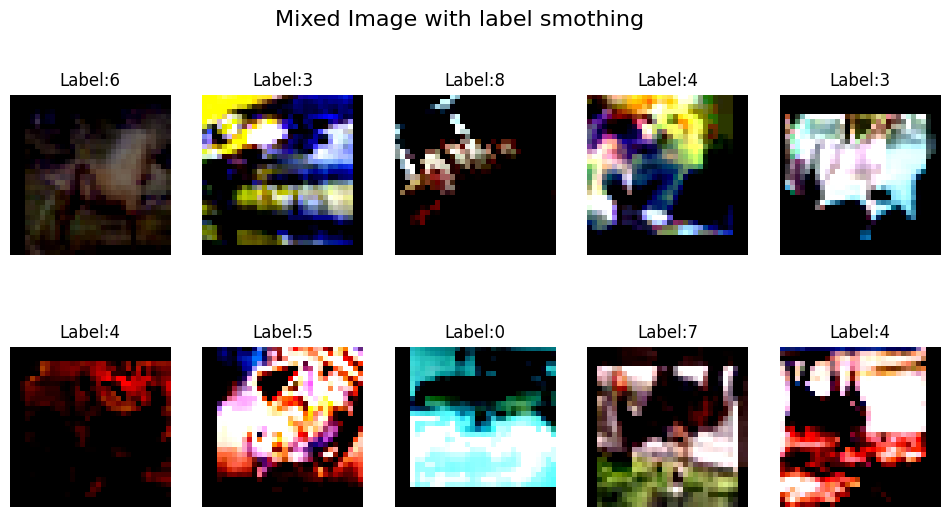

In [ ]:
num_epochs = 10

train_losses_no_mixup = []
train_losses_with_mixup = []

end_idx = 0
for epoch in range(num_epochs) :
    train_loss_no = 0.0
    train_loss = 0.0

    for inputs, labels in train_loader :
        optimizer.zero_grad()

        images_temp, labels_tmep = inputs, labels

        inputs, labels = mixup_data(inputs, labels)

        mixed_images = inputs.cpu().numpy()
        mixed_images = np.transpose(mixed_images, (0,2,3,1))
        mixed_images = np.squeeze(mixed_images)

        if end_idx == 0 :
            plot_images(mixed_images, labels.squeeze(), "Mixed Image with label smothing")
            end_idx = 1

        outputs_no_mixup = model(images_temp)
        outputs_mixup = model(inputs)

        labels = torch.squeeze(labels) # conver lables to 1D tensor

        loss_no_mixup = criterion(outputs_no_mixup, labels)

        loss_mixup = criterion(outputs_mixup, labels)

        loss_no_mixup.backward()
        loss_mixup.backward()

        optimizer.step()

        train_loss_no += loss_no_mixup.item()
        train_loss += loss_mixup.item()

    # 에포크 마다 손실 기록
    train_losses_no_mixup.append(train_loss_no / len(train_loader))
    train_losses_with_mixup.append(train_loss / len(train_loader))

In [ ]:
epochs = range(1, num_epochs +1 )

plt.plot(epochs, train_losses_no_mixup, label='No Mixed')
plt.plot(epochs, train_losses_with_mixup, label='Mixed')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()